# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
import os
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

('3.2.0', '4.47.1', '2.2.2+cu121')

In [3]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading dataset

In [4]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from datasets import Dataset, DatasetDict

# 1. Load the dataset
dataset = load_dataset("ucberkeley-dlab/measuring-hate-speech")
df = dataset["train"].to_pandas()

# 2. Select unique comments
df = df[["comment_id", "text", "hate_speech_score"]]

# 3. Create binary labels
df["label"] = (df["hate_speech_score"] > 0.5).astype(int)
data = df[["text", "label"]]

# 4. Split the data
train_df, temp_df = train_test_split(data, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert to Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [5]:
raw_datasets = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 94889
    })
    val: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 20333
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 20334
    })
})

In [6]:
data[data['label'] == 1].head(10)
#Sample hate speech

,text,label
4,For starters bend over the one in pink and kic...,1
7,Fuck off you insufferable retarded faggot.,1
14,White Small Little Invisible Clits Are A Disgr...,1
17,@suddenlywestan Because you are a country of m...,1
18,This sub is full of grade A faggots Comedy fu...,1
24,Get rid of them and their anchor babies and gr...,1
30,@KeGutta These niggas straight bitches,1
37,"Dwight Howard is a undercover Faggot, this guy...",1
48,@odysseuslahori @IqShoaib Hang till death all ...,1
50,Saudi should attack Iran and see what happens ...,1


In [7]:
label_list = ['non-toxic', 'toxic']
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'non-toxic': 0, 'toxic': 1}

In [8]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'non-toxic', 1: 'toxic'}

## 2. Model & Tokenization

In [9]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

2

<img src = "figures/BERT_embed.png" width=500>

In [10]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

2025-03-23 13:51:42.574803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742737902.597038  748510 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742737902.603990  748510 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742737902.622919  748510 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742737902.622933  748510 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742737902.622935  748510 computation_placer.cc:177] computation placer alr

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 3. Preprocessing 

In [11]:
# Define tokenize function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        # max_length=128,
        padding=True,
    )

In [12]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_datasets

Map:   0%|          | 0/94889 [00:00<?, ? examples/s]

Map:   0%|          | 0/20333 [00:00<?, ? examples/s]

Map:   0%|          | 0/20334 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 94889
    })
    val: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20333
    })
    test: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20334
    })
})

In [13]:
# # list(task_to_keys[task_name])
# column_dataset = [item for item in task_to_keys[task_name] if item is not None]
# column_dataset

In [14]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns("__index_level_0__")
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 94889
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20333
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20334
    })
})

In [15]:
tokenized_datasets['train'][0]['input_ids'].size()

torch.Size([149])

In [16]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

"[CLS] i don ' t care how threatened you feel, you can ' t go throwing respect for human rights and due process out the window and just blow a kid away to defend your shit. but this is america the free country founded on genocide and slavery where they hold people in prison camps for years without trial and property is worth more than life so [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

## 4. Preparing the dataloader

In [17]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [18]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150)
small_eval_dataset = tokenized_datasets["val"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(1000))

In [19]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [20]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 191]), torch.Size([32, 191]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [21]:
teacher_model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "non-toxic",
    "1": "toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "non-toxic": 0,
    "toxic": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [22]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig, BertModel, BertEncoder
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration
configuration['num_hidden_layers'] 

12

In [23]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2 
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [24]:
configuration

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "non-toxic",
    "1": "toxic"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "non-toxic": 0,
    "toxic": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [25]:
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [29]:
from torch.nn import Module

def distill_bert_weights(teacher: Module, student: Module, even_or_odd: str) -> None:
    """
    Recursively copies the weights from the teacher to the student.
    This function is meant to be first called on a BertFor... model, but is then called
    on every child module recursively.
    The only part that's not fully copied is the encoder, of which only half the layers are copied.
    """
    
    # Determine the starting offset based on even or odd choice.
    if even_or_odd == "even":
        e = 1
    elif even_or_odd == "odd":
        e = 0
    else:
        raise ValueError("even_or_odd must be either 'even' or 'odd'")
        
    # If the part is an entire BERT model or a BertFor... model, iterate through children
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, even_or_odd)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())]  # 12 layers
        student_encoding_layers = [layer for layer in next(student.children())]  # 6 layers
        for i in range(len(student_encoding_layers)):
            teacher_index = 2 * i + e  # Calculate the teacher layer index based on even_or_odd
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[teacher_index].state_dict())
    # Else the part is a head or something else, copy the state_dict directly
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [30]:
model_odd = distill_bert_weights(teacher=teacher_model, student=model, even_or_odd="odd")
model_even = distill_bert_weights(teacher=teacher_model, student=model, even_or_odd="even")

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model_odd))

Teacher parameters : 109483778
Student parameters : 66956546


In [32]:
count_parameters(model_odd)/count_parameters(teacher_model) * 100

61.156590705154514

In [33]:
#It has 40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [34]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [35]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

# Odds Model

## 6. Optimizer

In [36]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [37]:
#First try Odd Model
model = model_odd.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [38]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [39]:
# !pip3 install evaluate

In [40]:
import numpy as np
import evaluate
# Get the metric function
task_name = None
if task_name is not None:
    metric = evaluate.load("glue", task_name)
else:
    metric = evaluate.load("accuracy")

## 9. Train

In [41]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

# Lists to store losses for each epoch
train_losses = []
train_losses_cls = []
train_losses_div = []
train_losses_cos = []
eval_losses = []

for epoch in range(num_epochs):
    model.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
    train_losses.append(train_loss / len(train_dataloader))
    train_losses_cls.append(train_loss_cls / len(train_dataloader))
    train_losses_div.append(train_loss_div / len(train_dataloader))
    train_losses_cos.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/14830 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.1837:
  - Loss_cls: 0.4249
  - Loss_div: 0.0982
  - Loss_cos: 0.0280
Epoch at 1: Test Acc 0.9250
Epoch at 2: Train loss 0.1668:
  - Loss_cls: 0.3524
  - Loss_div: 0.1232
  - Loss_cos: 0.0248
Epoch at 2: Test Acc 0.9530
Epoch at 3: Train loss 0.1593:
  - Loss_cls: 0.3209
  - Loss_div: 0.1338
  - Loss_cos: 0.0233
Epoch at 3: Test Acc 0.9590
Epoch at 4: Train loss 0.1563:
  - Loss_cls: 0.3090
  - Loss_div: 0.1377
  - Loss_cos: 0.0222
Epoch at 4: Test Acc 0.9660
Epoch at 5: Train loss 0.1548:
  - Loss_cls: 0.3030
  - Loss_div: 0.1398
  - Loss_cos: 0.0217
Epoch at 5: Test Acc 0.9660
Avg Metric 0.9538


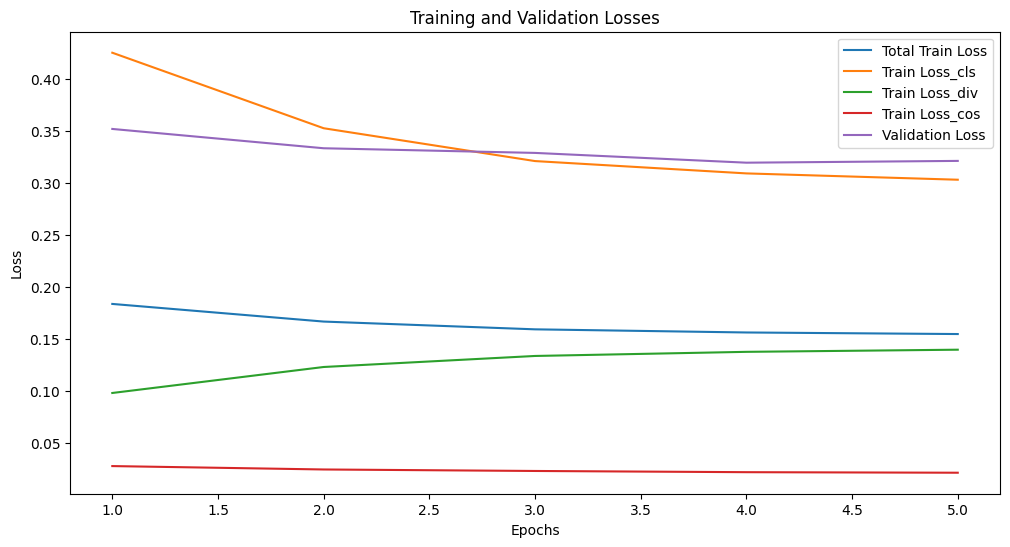

In [42]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses, label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Appendix (Teacher Model)

In [44]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss 
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)
    
        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/14830 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [45]:
model.save_pretrained('models/odd/')
tokenizer.save_pretrained('models/odd/')

('models/odd/tokenizer_config.json',
 'models/odd/special_tokens_map.json',
 'models/odd/vocab.txt',
 'models/odd/added_tokens.json',
 'models/odd/tokenizer.json')